# Occupation Network

In [1]:
import pandas as pd
import networkx as nx


## 1. Prepare Node Features

In [2]:
bls_data = pd.read_csv("data/2022 employment data.csv")

In [3]:
transitions = pd.read_csv("data/Transitions.csv", index_col = 0)

In [4]:
transitions

,current_ONET,next_ONET,update_value
0,41-3091.00,41-4012.00,24455
1,21-1021.00,41-3091.00,156
2,33-3051.00,43-5011.00,33
3,11-1021.00,11-3031.00,35671
4,11-2021.00,11-9111.00,7505
...,...,...,...
58037,51-6093.00,53-2021.00,1
58038,51-1011.00,51-3023.00,1
58039,29-2043.00,17-3022.00,1
58040,51-4111.00,51-8013.00,1


In [5]:
bls_data

,Categ,Priority,O*NET-SOC Code,Title,Description,Total Employment,Mean Hourly Wage,25th Percentile Hourly Wage,Median Hourly Wage,75th Percentile Hourly Wage,"Employment change, numeric, 2022-32","Employment change, percent, 2022-32"
0,mfg,1.0,11-3051.00,Industrial Production Managers,"Plan, direct, or coordinate the work activitie...","211,710",58.13,41.03,51.71,67.03,3.6,1.6
1,mfg,1.0,11-3051.01,Quality Control Systems Managers,"Plan, direct, or coordinate quality assurance ...","211,710",58.13,41.03,51.71,67.03,3.6,1.6
2,mfg,1.0,17-2112.00,Industrial Engineers,"Design, develop, test, and evaluate integrated...","321,400",47.39,37.31,46.32,56.25,38.4,11.7
3,mfg,1.0,17-2112.03,Manufacturing Engineers,"Design, integrate, or improve manufacturing sy...","321,400",47.39,37.31,46.32,56.25,38.4,11.7
4,mfg,1.0,17-2141.00,Mechanical Engineers,Perform engineering duties in planning and des...,"277,560",48.47,37.01,46.31,58.98,28.5,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1011,NaN,NaN,55-3014.00,Artillery and Missile Crew Members,"Target, fire, and maintain weapons used to des...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1012,NaN,NaN,55-3015.00,Command and Control Center Specialists,"Operate and monitor communications, detection,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1013,NaN,NaN,55-3016.00,Infantry,Operate weapons and equipment in ground combat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1014,NaN,NaN,55-3018.00,Special Forces,"Implement unconventional operations by air, la...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
bls_data.Categ.unique()

array(['mfg', 'wireless', 'space', 'mtls', 'micro', 'integsens', 'stats',
       'renew', 'HMI', 'cyber', 'bio', 'advcomp', nan], dtype=object)

In [7]:
# Attempt to convert 'Median Hourly Wage' to float, replacing non-convertible values with NaN
bls_data['Median Hourly Wage'] = pd.to_numeric(bls_data['Median Hourly Wage'].str.replace(',', ''), errors='coerce')


In [8]:
len(bls_data[bls_data['Median Hourly Wage'].isna()])

124

In [9]:
# Drop rows where 'Median Hourly Wage' could not be converted (i.e., is now NaN)
data_clean = bls_data.dropna(subset=['Median Hourly Wage'])

In [10]:
data_clean['sustainable_wage'] = data_clean['Median Hourly Wage'] - 25.02

C:\Users\ewp\AppData\Local\Temp\ipykernel_28120\1433648313.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['sustainable_wage'] = data_clean['Median Hourly Wage'] - 25.02


In [11]:
data_clean['sustainable_wage_ind'] = data_clean['sustainable_wage']>0

C:\Users\ewp\AppData\Local\Temp\ipykernel_28120\3289276827.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['sustainable_wage_ind'] = data_clean['sustainable_wage']>0


In [12]:
data_clean['stable_employment'] = data_clean['Employment change, numeric, 2022-32']>0

C:\Users\ewp\AppData\Local\Temp\ipykernel_28120\73909086.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['stable_employment'] = data_clean['Employment change, numeric, 2022-32']>0


In [13]:
data_clean['sustainable'] = (data_clean['sustainable_wage_ind']==True) & (data_clean['stable_employment']==True)

C:\Users\ewp\AppData\Local\Temp\ipykernel_28120\406032106.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['sustainable'] = (data_clean['sustainable_wage_ind']==True) & (data_clean['stable_employment']==True)


In [14]:
data_clean

,Categ,Priority,O*NET-SOC Code,Title,Description,Total Employment,Mean Hourly Wage,25th Percentile Hourly Wage,Median Hourly Wage,75th Percentile Hourly Wage,"Employment change, numeric, 2022-32","Employment change, percent, 2022-32",sustainable_wage,sustainable_wage_ind,stable_employment,sustainable
0,mfg,1.0,11-3051.00,Industrial Production Managers,"Plan, direct, or coordinate the work activitie...","211,710",58.13,41.03,51.71,67.03,3.6,1.6,26.69,True,True,True
1,mfg,1.0,11-3051.01,Quality Control Systems Managers,"Plan, direct, or coordinate quality assurance ...","211,710",58.13,41.03,51.71,67.03,3.6,1.6,26.69,True,True,True
2,mfg,1.0,17-2112.00,Industrial Engineers,"Design, develop, test, and evaluate integrated...","321,400",47.39,37.31,46.32,56.25,38.4,11.7,21.30,True,True,True
3,mfg,1.0,17-2112.03,Manufacturing Engineers,"Design, integrate, or improve manufacturing sy...","321,400",47.39,37.31,46.32,56.25,38.4,11.7,21.30,True,True,True
4,mfg,1.0,17-2141.00,Mechanical Engineers,Perform engineering duties in planning and des...,"277,560",48.47,37.01,46.31,58.98,28.5,10.0,21.29,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,NaN,NaN,53-7072.00,"Pump Operators, Except Wellhead Pumpers","Tend, control, or operate power-driven, statio...","10,870",28.44,21.51,26.86,35.67,0.4,3.6,1.84,True,True,True
993,NaN,NaN,53-7073.00,Wellhead Pumpers,Operate power pumps and auxiliary equipment to...,"14,550",31.50,22.80,30.42,38.04,-0.4,-2.2,5.40,True,False,False
994,NaN,NaN,53-7081.00,Refuse and Recyclable Material Collectors,Collect and dump refuse or recyclable material...,"132,240",21.91,16.37,20.94,25.87,4.7,3.2,-4.08,False,True,False
995,NaN,NaN,53-7121.00,"Tank Car, Truck, and Ship Loaders","Load and unload chemicals and bulk solids, suc...","12,470",28.21,21.40,25.93,36.38,0.2,1.6,0.91,True,True,True


In [15]:
data_clean.to_csv("bls_as_features.csv")

Note that 892 nodes have wage features and 124 do not!

## 2. Build Graph 

In [31]:
data_clean = pd.read_csv("data/bls_as_features.csv", index_col=0)

In [32]:
data_clean = data_clean.set_index("O*NET-SOC Code")

In [33]:
data_clean.head()

,Categ,Priority,Title,Description,Total Employment,Mean Hourly Wage,25th Percentile Hourly Wage,Median Hourly Wage,75th Percentile Hourly Wage,"Employment change, numeric, 2022-32","Employment change, percent, 2022-32",sustainable_wage,sustainable_wage_ind,stable_employment,sustainable
O*NET-SOC Code,,,,,,,,,,,,,,,
11-3051.00,mfg,1.0,Industrial Production Managers,"Plan, direct, or coordinate the work activitie...","211,710",58.13,41.03,51.71,67.03,3.6,1.6,26.69,True,True,True
11-3051.01,mfg,1.0,Quality Control Systems Managers,"Plan, direct, or coordinate quality assurance ...","211,710",58.13,41.03,51.71,67.03,3.6,1.6,26.69,True,True,True
17-2112.00,mfg,1.0,Industrial Engineers,"Design, develop, test, and evaluate integrated...","321,400",47.39,37.31,46.32,56.25,38.4,11.7,21.30,True,True,True
17-2112.03,mfg,1.0,Manufacturing Engineers,"Design, integrate, or improve manufacturing sy...","321,400",47.39,37.31,46.32,56.25,38.4,11.7,21.30,True,True,True
17-2141.00,mfg,1.0,Mechanical Engineers,Perform engineering duties in planning and des...,"277,560",48.47,37.01,46.31,58.98,28.5,10.0,21.29,True,True,True


In [34]:
trans_prob = pd.read_csv("data/Transition_Probab_Matrix.csv", index_col = 0)

In [35]:
trans_prob['11-1021.00'][trans_prob['11-1021.00']>0]

11-1011.00    0.080166
11-1011.03    0.044834
11-1021.00    0.254918
11-1031.00    0.032864
11-2011.00    0.035420
                ...   
55-3014.00    0.024496
55-3015.00    0.022249
55-3016.00    0.021010
55-3018.00    1.000000
55-3019.00    0.021650
Name: 11-1021.00, Length: 928, dtype: float64

In [36]:
DG = nx.DiGraph()

In [37]:
# Add nodes to graph
DG.add_nodes_from(trans_prob.index.tolist())

In [38]:
# Add node features 
for node, features in data_clean.iterrows():
    nx.set_node_attributes(DG, {node: features[['sustainable']].to_dict()})

In [39]:
# Check nodes 
DG.number_of_nodes()

1016

In [40]:
DG.nodes(data=True)

NodeDataView({'11-1011.00': {'sustainable': False}, '11-1011.03': {'sustainable': False}, '11-1021.00': {'sustainable': True}, '11-1031.00': {}, '11-2011.00': {'sustainable': True}, '11-2021.00': {'sustainable': True}, '11-2022.00': {'sustainable': True}, '11-2032.00': {'sustainable': True}, '11-2033.00': {'sustainable': True}, '11-3012.00': {'sustainable': True}, '11-3013.00': {'sustainable': True}, '11-3013.01': {'sustainable': True}, '11-3021.00': {'sustainable': True}, '11-3031.00': {'sustainable': True}, '11-3031.01': {'sustainable': True}, '11-3031.03': {'sustainable': True}, '11-3051.00': {'sustainable': True}, '11-3051.01': {'sustainable': True}, '11-3051.02': {'sustainable': True}, '11-3051.03': {'sustainable': True}, '11-3051.04': {'sustainable': True}, '11-3051.06': {'sustainable': True}, '11-3061.00': {'sustainable': True}, '11-3071.00': {'sustainable': True}, '11-3071.04': {'sustainable': True}, '11-3111.00': {'sustainable': True}, '11-3121.00': {'sustainable': True}, '11-

In [41]:
dict(DG.nodes(data=True))

{'11-1011.00': {'sustainable': False},
 '11-1011.03': {'sustainable': False},
 '11-1021.00': {'sustainable': True},
 '11-1031.00': {},
 '11-2011.00': {'sustainable': True},
 '11-2021.00': {'sustainable': True},
 '11-2022.00': {'sustainable': True},
 '11-2032.00': {'sustainable': True},
 '11-2033.00': {'sustainable': True},
 '11-3012.00': {'sustainable': True},
 '11-3013.00': {'sustainable': True},
 '11-3013.01': {'sustainable': True},
 '11-3021.00': {'sustainable': True},
 '11-3031.00': {'sustainable': True},
 '11-3031.01': {'sustainable': True},
 '11-3031.03': {'sustainable': True},
 '11-3051.00': {'sustainable': True},
 '11-3051.01': {'sustainable': True},
 '11-3051.02': {'sustainable': True},
 '11-3051.03': {'sustainable': True},
 '11-3051.04': {'sustainable': True},
 '11-3051.06': {'sustainable': True},
 '11-3061.00': {'sustainable': True},
 '11-3071.00': {'sustainable': True},
 '11-3071.04': {'sustainable': True},
 '11-3111.00': {'sustainable': True},
 '11-3121.00': {'sustainable'

In [42]:
# Display node features from the graph
node_features = pd.DataFrame.from_dict(dict(DG.nodes(data=True)), orient='index')


In [43]:
node_features

,sustainable
11-1011.00,False
11-1011.03,False
11-1021.00,True
11-2011.00,True
11-2021.00,True
...,...
53-7072.00,True
53-7073.00,False
53-7081.00,False
53-7121.00,True


In [44]:
# Add edges with weights 
for i, row in trans_prob.iterrows():
    for j, weight in row.items():
        if weight != 0:  # Only add edges with non-zero weights
            DG.add_edge(i, j, weight=round(weight,4))

In [45]:
better = pd.read_csv("data/updated_matrix.csv",index_col=0)

In [46]:
better

,11-1011.00,11-1011.03,11-1021.00,11-1031.00,11-2011.00,11-2021.00,11-2022.00,11-2032.00,11-2033.00,11-3012.00,...,55-3011.00,55-3012.00,55-3013.00,55-3014.00,55-3015.00,55-3016.00,55-3018.00,55-3019.00,99-9999.00,99-9990
ONET Numbers,,,,,,,,,,,,,,,,,,,,,
11-1011.00,0.00,0.00,-43.96,NaN,-29.66,-23.79,-28.33,-28.89,-39.49,-41.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11-1011.03,0.00,0.00,-43.96,NaN,-29.66,-23.79,-28.33,-28.89,-39.49,-41.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11-1021.00,43.96,43.96,0.00,NaN,14.30,20.17,15.63,15.07,4.47,2.52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11-1031.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11-2011.00,29.66,29.66,-14.30,NaN,0.00,5.87,1.33,0.77,-9.83,-11.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55-3016.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55-3018.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55-3019.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# Add edge features from wage comparison matrix
for source, row in better.iterrows():
    for target, edge_feature in row.items():
        if DG.has_edge(source, target) and edge_feature > 0:
            # Update the 'edge_feature' attribute for existing edges
            DG[source][target]['wage_diff'] = edge_feature

In [48]:
list(DG.edges(data=True))

[('11-1011.00', '11-1011.00', {'weight': 0.278}),
 ('11-1011.00', '11-1011.03', {'weight': 0.0}),
 ('11-1011.00', '11-1021.00', {'weight': 0.0802}),
 ('11-1011.00', '11-1031.00', {'weight': 0.0003}),
 ('11-1011.00', '11-2011.00', {'weight': 0.0016}),
 ('11-1011.00', '11-2021.00', {'weight': 0.0334}),
 ('11-1011.00', '11-2022.00', {'weight': 0.0432}),
 ('11-1011.00', '11-2032.00', {'weight': 0.0201}),
 ('11-1011.00', '11-2033.00', {'weight': 0.0002}),
 ('11-1011.00', '11-3012.00', {'weight': 0.0021}),
 ('11-1011.00', '11-3013.00', {'weight': 0.0006}),
 ('11-1011.00', '11-3013.01', {'weight': 0.0002}),
 ('11-1011.00', '11-3021.00', {'weight': 0.0213}),
 ('11-1011.00', '11-3031.00', {'weight': 0.0364}),
 ('11-1011.00', '11-3031.01', {'weight': 0.0122}),
 ('11-1011.00', '11-3031.03', {'weight': 0.0003}),
 ('11-1011.00', '11-3051.00', {'weight': 0.0017}),
 ('11-1011.00', '11-3051.01', {'weight': 0.0009}),
 ('11-1011.00', '11-3061.00', {'weight': 0.0021}),
 ('11-1011.00', '11-3071.00', {'wei

## 3. Neighbor-based measure

### a. Share of sustainable occupations

In [49]:
# Define the node for the analysis
specified_node = '53-7081.00'

In [50]:
# 1. Total number of degrees (in + out) of the specified node
total_out_degrees = DG.out_degree(specified_node)

In [51]:
total_out_degrees

188

In [52]:
DG.nodes[specified_node]['sustainable']

False

In [53]:
node_feature_condition = lambda node_attrs: node_attrs['sustainable'] == True


In [54]:
len(list(DG.successors(specified_node)))

188

Note: in a directed graph, .successors() = .neighbors()

In [55]:
# 2. Degrees to neighbors with a certain node feature (sustainable occupations)
neighbors_with_feature = []

for n in DG.successors(specified_node):
    print(n)
    if 'sustainable' in DG.nodes[n].keys():
        if DG.nodes[n]['sustainable'] == True:
            neighbors_with_feature.append(n)
            print('HERE',DG.nodes[n])

11-1011.00
11-1011.03
11-1021.00
HERE {'sustainable': True}
11-2011.00
HERE {'sustainable': True}
11-2021.00
HERE {'sustainable': True}
11-2022.00
HERE {'sustainable': True}
11-2032.00
HERE {'sustainable': True}
11-3012.00
HERE {'sustainable': True}
11-3021.00
HERE {'sustainable': True}
11-3031.01
HERE {'sustainable': True}
11-3051.00
HERE {'sustainable': True}
11-3051.01
HERE {'sustainable': True}
11-3061.00
HERE {'sustainable': True}
11-9021.00
HERE {'sustainable': True}
11-9041.00
HERE {'sustainable': True}
11-9051.00
HERE {'sustainable': True}
11-9111.00
HERE {'sustainable': True}
11-9151.00
HERE {'sustainable': True}
11-9199.00
HERE {'sustainable': True}
13-1011.00
HERE {'sustainable': True}
13-1021.00
13-1022.00
13-1041.01
HERE {'sustainable': True}
13-1071.00
HERE {'sustainable': True}
13-1081.00
HERE {'sustainable': True}
13-1082.00
HERE {'sustainable': True}
13-1111.00
HERE {'sustainable': True}
13-1141.00
HERE {'sustainable': True}
13-1151.00
HERE {'sustainable': True}
13-116

In [56]:
degrees_to_neighbors_with_feature = len(neighbors_with_feature)

In [57]:
degrees_to_neighbors_with_feature

76

In [58]:
SN = degrees_to_neighbors_with_feature/total_out_degrees

In [59]:
SN

0.40425531914893614

### b. Share of better occupations

In [60]:
# 3. Degrees to neighbors where the edge feature is satisfied
neighbors_with_edge_feature = []

for n in DG.successors(specified_node):
    if 'wage_diff' in DG.edges[specified_node,n].keys():
        print(DG.edges[specified_node,n])
        if DG.edges[specified_node,n]['wage_diff'] >0:
            neighbors_with_edge_feature.append(n)
            print('HERE',n, DG.edges[specified_node,n]['wage_diff'] )

{'weight': 0.0114, 'wage_diff': 70.18}
HERE 11-1011.00 70.18
{'weight': 0.0038, 'wage_diff': 70.18}
HERE 11-1011.03 70.18
{'weight': 0.0267, 'wage_diff': 26.22}
HERE 11-1021.00 26.22
{'weight': 0.0038, 'wage_diff': 40.52}
HERE 11-2011.00 40.52
{'weight': 0.0057, 'wage_diff': 46.39}
HERE 11-2021.00 46.39
{'weight': 0.0114, 'wage_diff': 41.85}
HERE 11-2022.00 41.85
{'weight': 0.0114, 'wage_diff': 41.29}
HERE 11-2032.00 41.29
{'weight': 0.0019, 'wage_diff': 28.74}
HERE 11-3012.00 28.74
{'weight': 0.0019, 'wage_diff': 57.94}
HERE 11-3021.00 57.94
{'weight': 0.0095, 'wage_diff': 46.27}
HERE 11-3031.01 46.27
{'weight': 0.0019, 'wage_diff': 30.77}
HERE 11-3051.00 30.77
{'weight': 0.0019, 'wage_diff': 30.77}
HERE 11-3051.01 30.77
{'weight': 0.0019, 'wage_diff': 42.21}
HERE 11-3061.00 42.21
{'weight': 0.0019, 'wage_diff': 27.85}
HERE 11-9021.00 27.85
{'weight': 0.0114, 'wage_diff': 55.94}
HERE 11-9041.00 55.94
{'weight': 0.0019, 'wage_diff': 8.54}
HERE 11-9051.00 8.54
{'weight': 0.0038, 'wage_d

In [61]:
degree_neighbors_with_edge_feature = len(neighbors_with_edge_feature)
degree_neighbors_with_edge_feature
BN = degree_neighbors_with_edge_feature/total_out_degrees

In [62]:
BN

0.601063829787234

### c. Weighted Measures

In [89]:
# Weighted Degrees to neighbors with a certain node feature (sustainable occupations)
weighted_SN_num = 0 
weighted_denom = 0

for n in DG.successors(specified_node):
    weighted_denom += DG.edges[specified_node,n]['weight']
    if 'sustainable' in DG.nodes[n].keys():
        if DG.nodes[n]['sustainable'] == True:
            weighted_SN_num += DG.edges[specified_node,n]['weight']
            print('HERE',DG.nodes[n])
            print(DG.edges[specified_node,n]['weight'])

HERE {'sustainable': True}
0.0267
HERE {'sustainable': True}
0.0038
HERE {'sustainable': True}
0.0057
HERE {'sustainable': True}
0.0114
HERE {'sustainable': True}
0.0114
HERE {'sustainable': True}
0.0019
HERE {'sustainable': True}
0.0019
HERE {'sustainable': True}
0.0095
HERE {'sustainable': True}
0.0019
HERE {'sustainable': True}
0.0019
HERE {'sustainable': True}
0.0019
HERE {'sustainable': True}
0.0019
HERE {'sustainable': True}
0.0114
HERE {'sustainable': True}
0.0019
HERE {'sustainable': True}
0.0038
HERE {'sustainable': True}
0.0057
HERE {'sustainable': True}
0.0381
HERE {'sustainable': True}
0.0019
HERE {'sustainable': True}
0.0057
HERE {'sustainable': True}
0.0057
HERE {'sustainable': True}
0.0019
HERE {'sustainable': True}
0.0076
HERE {'sustainable': True}
0.0019
HERE {'sustainable': True}
0.0019
HERE {'sustainable': True}
0.0076
HERE {'sustainable': True}
0.0019
HERE {'sustainable': True}
0.0076
HERE {'sustainable': True}
0.0057
HERE {'sustainable': True}
0.0076
HERE {'sustain

In [90]:
weighted_SN_num

0.4298000000000007

In [91]:
weighted_denom

0.9981000000000022

In [92]:
# Weighted Degrees to neighbors with a certain node feature (sustainable occupations)
weighted_BN_num = 0 

for n in DG.successors(specified_node):
    # Denominator computed above
    if 'wage_diff' in DG.edges[specified_node,n].keys():
        print(DG.edges[specified_node,n])
        if DG.edges[specified_node,n]['wage_diff'] >0:
            weighted_BN_num += DG.edges[specified_node,n]['weight']


{'weight': 0.0114, 'wage_diff': 70.18}
{'weight': 0.0038, 'wage_diff': 70.18}
{'weight': 0.0267, 'wage_diff': 26.22}
{'weight': 0.0038, 'wage_diff': 40.52}
{'weight': 0.0057, 'wage_diff': 46.39}
{'weight': 0.0114, 'wage_diff': 41.85}
{'weight': 0.0114, 'wage_diff': 41.29}
{'weight': 0.0019, 'wage_diff': 28.74}
{'weight': 0.0019, 'wage_diff': 57.94}
{'weight': 0.0095, 'wage_diff': 46.27}
{'weight': 0.0019, 'wage_diff': 30.77}
{'weight': 0.0019, 'wage_diff': 30.77}
{'weight': 0.0019, 'wage_diff': 42.21}
{'weight': 0.0019, 'wage_diff': 27.85}
{'weight': 0.0114, 'wage_diff': 55.94}
{'weight': 0.0019, 'wage_diff': 8.54}
{'weight': 0.0038, 'wage_diff': 29.46}
{'weight': 0.0057, 'wage_diff': 14.75}
{'weight': 0.0381, 'wage_diff': 40.9}
{'weight': 0.0019, 'wage_diff': 18.74}
{'weight': 0.0057, 'wage_diff': 13.53}
{'weight': 0.0057, 'wage_diff': 9.94}
{'weight': 0.0019, 'wage_diff': 16.33}
{'weight': 0.0076, 'wage_diff': 24.91}
{'weight': 0.0019, 'wage_diff': 24.87}
{'weight': 0.0019, 'wage_dif

In [94]:
weighted_BN_num

0.6332000000000008

In [93]:
weighted_denom

0.9981000000000022

## 4. Plotting example

In [ ]:
import matplotlib.pyplot as plt

# Create a subgraph from the specified node and its neighbors
subgraph_nodes = [specified_node] + list(DG.neighbors(specified_node))
subgraph = DG.subgraph(subgraph_nodes)

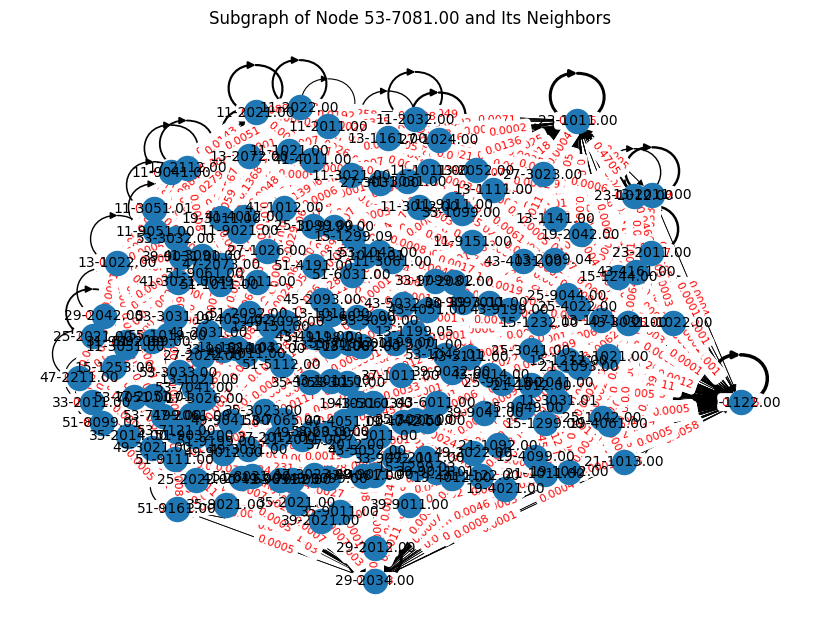

In [ ]:
# Draw the subgraph
pos = nx.spring_layout(subgraph)  # Position nodes using the spring layout

# Extract edge weights as a dictionary
edge_labels = nx.get_edge_attributes(subgraph, 'weight')
# Define edge widths based on the edge weights
edge_widths = [0.5 + 3 * weight for weight in edge_labels.values()]  # You can adjust this scaling factor as needed

# Visualize the graph
plt.figure(figsize=(8, 6))

nx.draw(subgraph, pos, with_labels=True,
        width=edge_widths, alpha=1, font_size=10)
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels,
                             font_color='red', font_size=8, label_pos=0.5)

plt.title("Subgraph of Node {} and Its Neighbors".format(specified_node))
plt.show()
